# Self-organizing maps

### What is a self-organizing map?

A self-organizing map (SOM) is a type or artificial neural network that is able to produce a low-dimensional representation of the input space through unsupervised training. Contrary to the well-known approach of error-correction learning (the one seen in the most common neural networks), SOMs apply competitive learning, where only one neuron (known as the Best Matching Unit) is activated when a sample is passed through the map.

##### How is this useful?

To keep things simple, SOMs reduce the dimensionality of the data, allowing us to discern and discover groups in an 2D, easier to read representation of the data.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
plt.style.use('seaborn')

We'll use colors as the training data. For that, we'll use numpy's function random.randint; we'll get 100 samples of RGB colors (values ranging from 0 to 255).

In [2]:
colors = np.random.randint(0, 256, (100, 3))
# Min max normalization:
colors = (colors - colors.min()) / (colors.max() - colors.min())

Now we'll specify our SOM's shape; the ammount of connections its neurons will have depends on our training data. In this case, for RGB colors, every neuron will have 3 connections with the input, which results in 3 weights per neuron.

In [3]:
map_side = 15
_, connections = colors.shape
weight_matrix = np.random.random((map_side, map_side, connections))

And its training parameters:

In [4]:
epochs = 10000
learning_rate = 0.2
neighborhood = map_side / 2

Helper matrix

We create an index matrix in order to calculate physical proximity between neurons; we do this in order to determine which neurons to update after every epoch; wether they are in the BMU's neighborhood or not.

In [5]:
idx_matrix = []
for y in range(map_side):
    row = []
    for x in range(map_side):
        row.append([y, x])
    idx_matrix.append(row)
idx_matrix = np.array(idx_matrix)

## Training functions

Now we'll implement the functions needed to train our SOM

### Best Matching Unit

The Best Matching Unit or BMU is the node/neuron closer to the input; there will only be one BMU per input.

In order to find it, first, we determine the distance from every neuron to the input pattern. For that, we calculate the euclidean distance (without the square root in order to save computing power and time) between the
input pattern and the weight matrix:
```python
distances = np.sum(((w_matrix - input_pattern)**2), axis=2)
```
This gives us a matrix containing the distance between every neuron and the input pattern. Now, we need to find the value and the position of the minimum value of the distances matrix. We'll use np.where for that:
```python
bmu_idx = np.where(distances == distances.min())
```
Now, with the BMU's coordinates, we can find its weights:
```python
bmu = w_matrix[bmu_idx[0], bmu_idx[1], :]
```

In [6]:
def find_bmu(input_pattern, w_matrix):
    distances = np.sum((w_matrix - input_pattern)**2, axis=2)
    bmu_idx = np.where(distances == distances.min())
    bmu_idx = np.array(bmu_idx).ravel()
    bmu = w_matrix[bmu_idx[0], bmu_idx[1], :]
    
    return bmu, bmu_idx

### Updating the learning rate

The learning rate determines how much the neurons' weights change during the training. At first, a "high" learning rate will make the neurons approach the distribution of the training data, but the learning rate must be reduced throughout the training to prevent the neurons from wandering around endlessly and to allow them to converge to their final position.

There are several ways of reducing the learning rate during the training; in this case, we'll make the learning rate descent in a linear way:

<center>
$\alpha_{i} = \alpha_{0} - \frac{\alpha_{\lambda}}{e_{\lambda}} e_{i}$
</center>

$\alpha_{i}$: learning rate for the ith epoch<br>
$\alpha_{0}$: initial learning rate<br>
$e_{i}$: current epoch<br>
$e_{\lambda}$: total number of epochs<br>

In [7]:
def lr_update(initial_lr, current_iteration, max_iterations):
    return initial_lr - (initial_lr / max_iterations) * current_iteration

### Updating the neighbourhood

The neighborhood defines how many neurons around the BMU will be updated; normally, the further away from the BMU, the less the neurons are affected by the weight update. There are several ways to obtain whether a neuron is inside the neighborhood or not, like the Euclidean distance or the Manhattan distance. For this example, we'll use the Euclidean.

The neighborhood will be updated in a similar manner to the learning rate:

In [8]:
def nb_update(initial_neighborhood, current_iteration, max_iterations):
    return initial_neighborhood - (initial_neighborhood / max_iterations) * current_iteration

### Calculating the decay

As mentioned before, neurons further away from the BMU will see their weights updated too, tho in a reduced manner. As with the learning rate and the neighborhood decay, there are multiple ways to approach the learning rate decay, from a linear to a Gaussian function. The latter will be the one used in this case:

In [14]:
def lr_decay(distance, current_nb):
    a = 1 / np.sqrt(2 * np.pi)
    c = np.max(distance) / 2
    
    return np.exp(-(distance**2) / (2 * c**2))

#### Visualizing the different decays

Let's take a look at how the different decays look like:

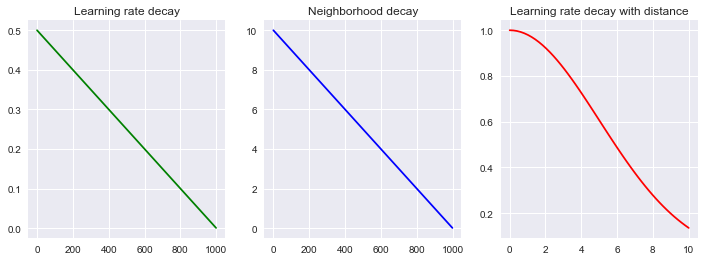

In [38]:
initial_lr = 0.5
initial_nb = 10
lr_values = []
nb_values = []

max_iterations = 1000

for i in range(max_iterations):
    lr_values.append(lr_update(initial_lr, i, max_iterations))
    nb_values.append(nb_update(initial_nb, i, max_iterations))

distances = np.linspace(0, 10)
other_lr = lr_decay(distances, 5)

plot_values = [lr_values, nb_values]
titles = ['Learning rate decay', 'Neighborhood decay']
colors = ['g', 'b']

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for i, (value, title, color) in enumerate(zip(plot_values, titles, colors)):
    ax[i].plot(np.arange(len(value)), value, color=color)
    ax[i].set_title(title)
ax[2].plot(distances, other_lr, color='r')
ax[2].set_title('Learning rate decay with distance')
plt.show()

##### Showing the output

In [12]:
def show_map(w_matrix, i):
    clear_output(wait=True)
    plt.imshow(w_matrix)
    plt.title(f'SOM after {i} epochs')
    plt.axis('off')
    plt.show()

### Training

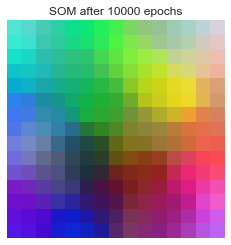

In [15]:
for epoch in range(epochs):
    # We take a sample from the dataset
    sample = colors[np.random.randint(0, 100)]

    # Then, we find the best matching unit and its index for that sample
    bmu, bmu_idx = find_bmu(sample, weight_matrix)

    # Before making any operations, we determine the learning rate and neighborhood for the current epoch
    current_lr = lr_update(learning_rate, epoch, epochs)
    current_nb = nb_update(neighborhood, epoch, epochs)

    # Now we obtain the distance between each neuron and the BMU in order to find out what neurons to update
    distances = np.sqrt(np.sum((idx_matrix - bmu_idx)**2, axis=2))
    # Only the neurons inside the BMU's neighborhood will be updated 
    affected_neurons = distances <= current_nb

    # Before updating them, we have to obtain the decay on the learning rate; the further away from the BMU
    # the less they'll learn
    decay = lr_decay(distances, current_nb)
    # Finally, we update the affected neurons taking decay into account;
    # We follow the formula:
    # W(i + 1) = W(i) + decay * current_learning_rate * (sample - W(i))
    # Being:
    # W(i): the weights for the current iteration
    # decay: a constraint in learning due to distance from the BMU
    # current_learning_rate: the learning rate corresponding to the current epoch
    # sample: the sample taken from the training set
    weight_matrix[affected_neurons] = weight_matrix[affected_neurons] + np.expand_dims(decay[affected_neurons], axis=2) \
                                      * current_lr * (sample - weight_matrix[affected_neurons])

    if (epoch + 1) % 5000 == 0 or epoch == 0:
        show_map(weight_matrix, epoch + 1)

### SOM class

Let's pack things up and experiment. We'll tailor the functions we just used to our needs:

In [69]:
class SOM:
    def __init__(self, map_side=10, input_dim=3, learning_rate=0.3, neighborhood=None):
        self.weight_matrix = np.random.random((map_side, map_side, input_dim))
        self.learning_rate = learning_rate
        if neighborhood is None:
            self.neighborhood = map_side / 2
        else:
            self.neighborhood = neighborhood

    def _show_3dmap(self, i=None):
        clear_output(wait=True)
        plt.figure(figsize=(8, 8))
        
        plt.imshow(self.weight_matrix)
        plt.axis('off')
        if i is not None:
            plt.title(f'SOM after {i} epochs')
        plt.show()
    
    def _show_2dmap(self, data, i=None):
        clear_output(wait=True)
        plt.figure(figsize=(8, 8))
        
        plt.scatter(data[:, 0], data[:, 1])
        
        plt.triplot(self.weight_matrix[:, :, 0].ravel(), self.weight_matrix[:, :, 1].ravel(), zorder=1, c='r')
        plt.scatter(self.weight_matrix[:, :, 0], self.weight_matrix[:, :, 1], zorder=2, c='r')
        
        plt.gca().set_aspect('equal')
        if i is not None:
            plt.title(f'SOM after {i} epochs')
        plt.show()
        
    def find_bmu(self, input_pattern):
        distances = np.sum((self.weight_matrix - input_pattern)**2, axis=2)
        bmu_idx = np.where(distances == distances.min())
        bmu_idx = np.array(bmu_idx).ravel()
        bmu = self.weight_matrix[bmu_idx[0], bmu_idx[1], :]
        return bmu, bmu_idx
    
    @staticmethod
    def lr_update(initial_lr, current_iteration, max_iterations):
        return initial_lr - (initial_lr / max_iterations) * current_iteration
    
    @staticmethod
    def nb_update(initial_neighborhood, current_iteration, max_iterations):
        return initial_neighborhood - (initial_neighborhood / max_iterations) * current_iteration
    
    @staticmethod
    def lr_decay(distance, current_nb):
        a = 1 / np.sqrt(2 * np.pi)
        c = np.max(distance) / 2

        return np.exp(-(distance**2) / (2 * c**2))
    
    def train(self, dataset, epochs=1000, show_progress=True, interval=100, normalize_inputs=True):
        if normalize_inputs:
            dataset = (dataset - dataset.min()) / (dataset.max() - dataset.min())
        
        idx_matrix = []
        for y in range(self.weight_matrix.shape[0]):
            row = []
            for x in range(self.weight_matrix.shape[1]):
                row.append([y, x])
            idx_matrix.append(row)
        idx_matrix = np.array(idx_matrix)
        
        for epoch in range(epochs):
            sample = dataset[np.random.randint(0, dataset.shape[0])]
            bmu, bmu_idx = self.find_bmu(sample)
            
            current_lr = self.lr_update(self.learning_rate, epoch, epochs)
            current_nb = self.nb_update(self.neighborhood, epoch, epochs)
            
            distances = np.sqrt(np.sum((idx_matrix - bmu_idx)**2, axis=2))
            affected_neurons = distances <= current_nb
            decay = self.lr_decay(distances, current_nb)
            
            self.weight_matrix[affected_neurons] = self.weight_matrix[affected_neurons] \
                                                   + np.expand_dims(decay[affected_neurons], axis=2) \
                                                   * current_lr * (sample - self.weight_matrix[affected_neurons])
            
            if show_progress:
                if (epoch + 1) % interval == 0 or epoch == epochs-1:
                    if dataset.shape[-1] == 2:
                        self._show_2dmap(dataset, epoch + 1)
                    else:
                        self._show_3dmap(epoch + 1)

#### 2D SOM

What if we tried a 2D SOM? Let's see what happens if we use our map with points from a 2D circle:

In [81]:
theta = np.linspace(0, 2*np.pi, 100)
a, b = np.cos(theta), np.sin(theta)
dataset = np.array(list(zip(a, b)))

9 neurons:

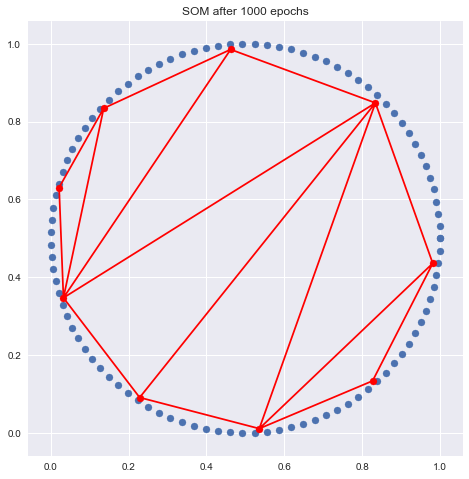

In [82]:
som2d = SOM(map_side=3, input_dim=2, neighborhood=0.5, learning_rate=0.4)
som2d.train(dataset, epochs=1000, interval=100)

16 neurons:

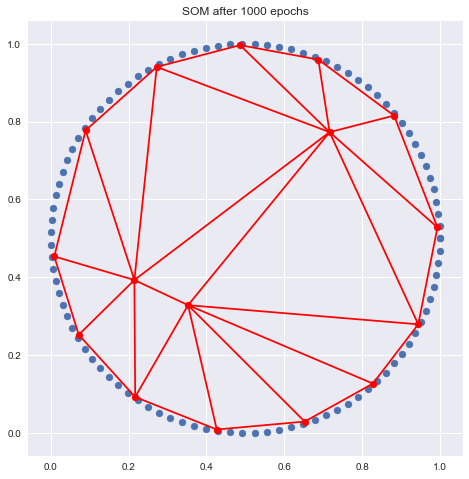

In [83]:
som2d = SOM(map_side=4, input_dim=2, neighborhood=0.5, learning_rate=0.4)
som2d.train(dataset, epochs=1000, interval=100)

#### 3D SOM

In [99]:
dataset = np.random.randint(0, 256, (100, 3))

225 neurons:

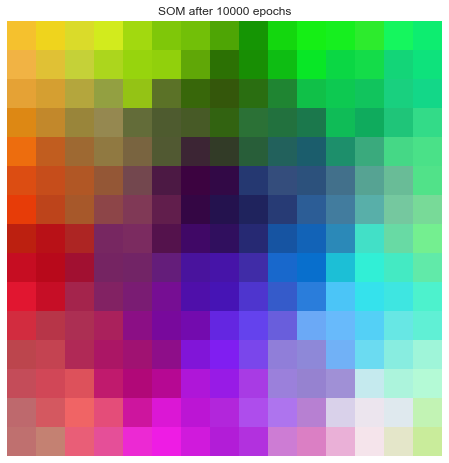

In [100]:
som = SOM(map_side=15, input_dim=3, learning_rate=0.6)
som.train(dataset, epochs=10000, show_progress=True, interval=2000)

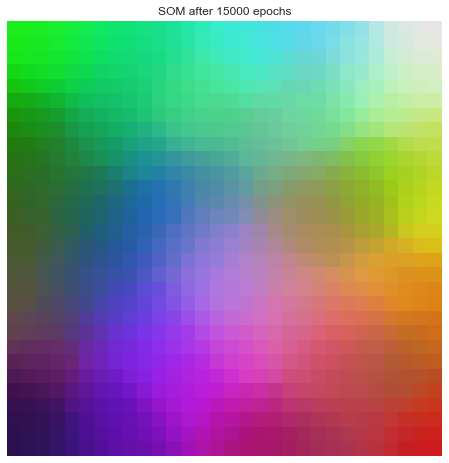

In [109]:
som = SOM(map_side=30, input_dim=3, learning_rate=0.2, neighborhood=30)
som.train(dataset, epochs=15000, show_progress=True, interval=5000)

900 neurons:

### Further reading and questions

When training neural networks we use metrics such as loss and accuracy to measure their performance. How would you measure a SOM's performance?

How do we dedice which hyperparameters are better for our SOM and our dataset? How many units should it have? What about the learning rate?